# Определение токсичных комментариев

В данном проекте необходимо получить модель, способную классифицировать комментарии к товарам в интернет-магазине на позитивные и негативные.

Необходимо построить модель со значением метрики качества F1 не меньше 0.75.

## План работы

### Шаг 1. Загрузка и подготовка данных
- [1. Импорт библиотек, изучение данных](#section1)
- [2. Подготовка данных](#section2)

### Шаг 2. Обучение моделей
- [1. Создание пайплайна](#section3)
- [2. Анализ результатов](#section4)
- [3. Проверка на адекватность](#section5)
- [4. Предсказания на модели BERT](#section6)

## Шаг 1. Загрузка и подготовка данных

<a id='section1'></a>

#### 1. Импорт библиотек, изучение данных

Для начала импортируем все библиотеки, потребующиеся в данной работе.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

import warnings
warnings.simplefilter('ignore')

import torch
import transformers
from tqdm import notebook

Далее прочитаем файл с данными и изучим общую информацию.

In [2]:
# Путь к файлу на локальном компьютере
path = 'datasets/toxic_comments.csv'

df = pd.read_csv(path)
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Данные состоят из двух столбцов. Столбец text содержит текст комментариев. Столбец toxic - информацию о токсичности комментария. 

Проверим распределение классов.

In [3]:
df['toxic'].mean()

0.10167887648758234

Токсичных комментариев 10% от общего числа. Учтём это при обучении моделей.

<a id='section2'></a>

#### 2. Подготовка данных

В данной работе попробуем два различных подхода к генерации признаков. Первый - TF-IDF. Второй - с помощью модели BERT.

Если BERT может самостоятельно токинизировать набор текстов, то для первого подхода потребуется подготовить текст.

In [4]:
# Переведем текст в нужный формат
df['corpus'] = df['text'].values.astype('U')

# Подготовим лемматизатор
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer = WordNetLemmatizer()

# Создадим функцию лемматизации текстов
def lemmas(text):
    '''
    Функция выполняет лемматизацию текста (text)
    '''
    word_list = nltk.word_tokenize(text)
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in word_list])
    return lemmatized_text

# Лемматизируем столбец
df['lemmas'] = df['corpus'].apply(lemmas)

# Скачаем стоп слова
nltk.download('stopwords')

# Получим набор слов для требуемого языка
stopwords = set(stopwords.words('english'))

# Создадим счетчик TF-IDF для корпуса текста
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Вывод

Данные загружены и изучены. Для выполнения обучения модели на основе TF-IDF была произведена лемматизация, подготовлен счетчик для выполнения трансформации в пайплайне.

## Шаг 2. Обучение моделей

<a id='section3'></a>

#### 1. Создание пайплайна

В первую очередь выделим признак и целевой признак, разделим данные на тренировочную и тестовую выборки.

In [5]:
# Выделим признаки и целевой признак
X = df['lemmas']
y = df['toxic']

random_state = 321
# Разделим на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_state)

Создадим метрику и разделим тренировочную выборку на фолды для выполнения кросс-валидации.

In [6]:
# Создадим метрику
f1 = make_scorer(f1_score, greater_is_better=True)

# Разделим на фолды
kfs = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state).split(X_train, y_train))

Теперь сформируем пайплайн. Так как признаков для обучения получится очень много, будем варьировать гиперпараметры только у модели логистической регрессии, так как она работает очень быстро на большом объеме данных, и у модели бустинга, так как она в принципе работает быстро. Деревянные модели попробуем "из коробки". 

In [7]:
# Сформируем пайплайн
estimators = [('transformer', count_tf_idf),
              ('model', LogisticRegression(class_weight='balanced'))
             ]
pipe = Pipeline(estimators)

# Зададим варианты изменения гиперпараметров
param_grid = [{'model': [LogisticRegression(class_weight='balanced')],
               'model__C': [0.1, 1, 10, 100]
              },
              {'model': [DecisionTreeClassifier(random_state=random_state, class_weight='balanced')],
              },
              {'model': [RandomForestClassifier(random_state=random_state, class_weight='balanced')],               
              },
              {'model': [LGBMClassifier(class_weight='balanced')],
               'model__num_leaves': range(6, 32, 5),
               'model__learning_rate': [0.005, 0.01, 0.05, 0.2, 0.5],
              }
             ]
# Опишем GridSearchCV
grid = GridSearchCV(pipe,
                    param_grid,                          
                    scoring=f1,
                    n_jobs=-1,
                    cv=kfs,
                    verbose=1
                   )

In [8]:
%%time
grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 21.2min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 48.1min finished


Wall time: 48min 18s


GridSearchCV(cv=[(array([     1,      2,      3, ..., 127653, 127654, 127655]),
                  array([     0,     14,     18, ..., 127647, 127650, 127651])),
                 (array([     0,      1,      3, ..., 127653, 127654, 127655]),
                  array([     2,      4,      9, ..., 127638, 127642, 127645])),
                 (array([     0,      1,      2, ..., 127651, 127652, 127653]),
                  array([     3,      5,      8, ..., 127644, 127654, 127655])),
                 (array([     0,      2,      3, ..., 127653, 127654, 127655]),
                  array([     1,      7,     12, ..., 127632, 127646, 127648])),
                 (a...
                          'model__C': [0.1, 1, 10, 100]},
                         {'model': [DecisionTreeClassifier(class_weight='balanced',
                                                           random_state=321)]},
                         {'model': [RandomForestClassifier(class_weight='balanced',
                           

<a id='section4'></a>

#### 2. Анализ результатов

Визуализируем результаты расчетов.

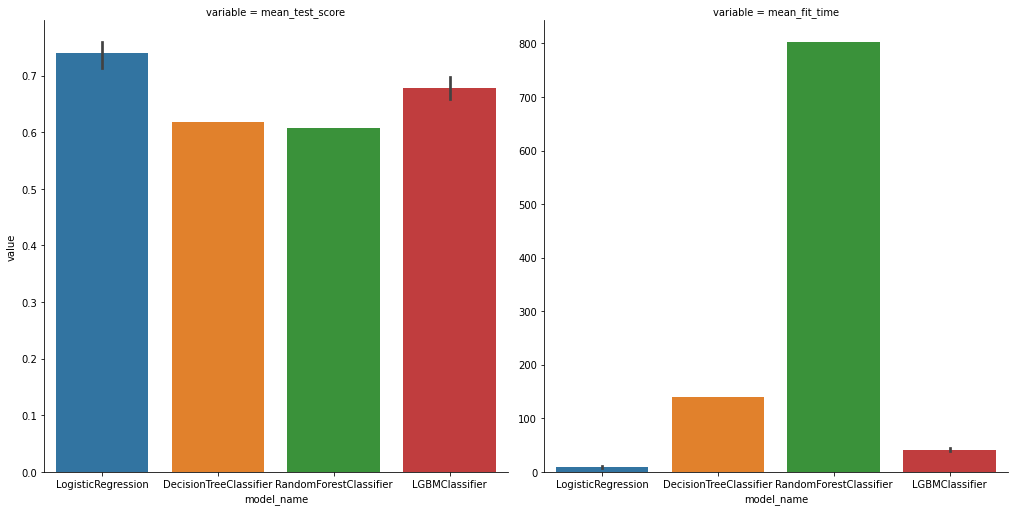

In [9]:
# Получим результаты расчетов
results = pd.DataFrame(grid.cv_results_)

# Напишем функцию получения имени модели
def model_name(data):
    return data['param_model'].__class__.__name__

# Добавим в результаты столбец с названиями моделей
results['model_name'] = results.apply(model_name, axis=1)

# Сформируем лонг-форм датафрейм с результатами
results_long = (pd.melt(results[['mean_test_score', 'mean_fit_time']]) \
                .join(pd.concat([results['model_name'], results['model_name']], ignore_index=True)))

# Построим графики
sns.catplot(data=results_long,
            x='model_name',
            y='value',
            col='variable',
            sharey=False,
            kind='bar',
            height=7
           )
plt.show()

Представленный выше график, показывающий средние значения метрики на обучающей выборке и среднее время обучения, а так же разброс значений для моделей, в которых менялись гиперпараметры, позволяет сделать несколько выводов:
- Модель логистической регрессии обучается очень быстро и имеет максимальные значения метрики f1 среди всех моделей
- Модель градиентного бустинга обучается дольше, результат показывает хуже
- Деревянные модели показывают наихудшие результаты, к тому же обучаются слишком долго (случайный лес обучается 15 минут, в то время как логистическая регрессия обучается примерно 10 секунд)

Выберем лучшую модель с лучшими гиперпараметрами и узнаем точное значение метрики на тренировочной выборке.

In [10]:
# Получим лучшую модель
pipe = grid.best_estimator_
pipe

Pipeline(steps=[('transformer',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model', LogisticRegression(C=10, class_weight='balanced'))])

In [11]:
print('f1 лучшей модели на тренировочной выборке =', (grid.best_score_ ))

f1 лучшей модели на тренировочной выборке = 0.7643536839308194


Проверим лучшую модель на тестовой выборке

In [12]:
%%time
pipe.fit(X_train, y_train)
print('f1 лучшей модели на тестовой выборке =', f1_score(y_test, pipe.predict(X_test)))

f1 лучшей модели на тестовой выборке = 0.7657683486238532
Wall time: 10.7 s


Задача выполнена, метрика f1 > 0.75.

Построим confusion matrix для предсказаний модели.

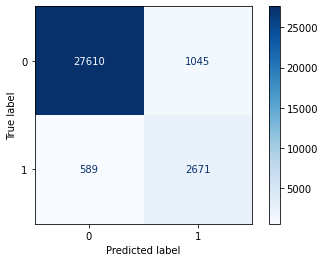

In [13]:
# Построим Confusion Matrix
disp = plot_confusion_matrix(pipe, X_test, y_test,                             
                             cmap=plt.cm.Blues
                             )
plt.show()

<a id='section5'></a>

#### 3. Проверка на адекватность

Проверим модель на адекватность. Сравнивать f1 с константной моделью некорректно, так как в данных наблюдается сильный перевес в сторону нулевого класса, а f1 для модели, выдающей всегда ноль, посчитать нельзя. Поэтому построим кривую ROC и посмотрим, как сильно отличается эта кривая от кривой случайной модели.

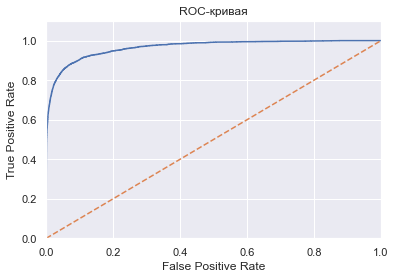

In [14]:
# Получим вероятности классов
probabilities_test = pipe.predict_proba(X_test)
# Выделим вероятности положительного класса
probabilities_one_test = probabilities_test[:, 1]

# Определим параметры ROC
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

sns.set()
plt.figure()

# Построим ROC
plt.plot(fpr, tpr)
# ROC случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')

# Установим границы осей
plt.xlim(0,1)
plt.ylim(0,1.1)
# Подпишем оси
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Добавим название
plt.title('ROC-кривая')
plt.show()

Проверку на адекватность модель прошла, ROC кривая выглядит отлично.

<a id='section6'></a>

#### 4. Предсказания на модели BERT

Попробуем использовать модель BERT для наших данных и сравним её результаты с нашими.

In [15]:
# Токенизируем текст, используем предобученную модель
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')
tokenized = df['text'].apply(lambda x: tokenizer.encode(x[:512], add_special_tokens=True ))

In [16]:
# Найдем максимальную длину массива
max_len = len(max(tokenized, key=len))
# Сделаем все массивы одной длины, заполнив недостающие значения нулями
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
# Сделаем маску для ненулевых значений
attention_mask = np.where(padded != 0, 1, 0)

In [17]:
# Загрузим предобученную модель
model = transformers.BertModel.from_pretrained('bert-base-multilingual-cased')

Вычисления на видеокарте идут значительно быстрее, поэтому поместим модель и матрицы в память видеокарты.

In [18]:
model.to('cuda')
padded = torch.LongTensor(padded).to('cuda')
attention_mask = torch.LongTensor(attention_mask).to('cuda')

Эмбеддинги будем делать на батчах небольшой длины, так как в видеопамять всё не поместится

In [19]:
# Укажем размер батчка
batch_size = 20
embeddings = []
# Сформируем эмбеддинги
for i in notebook.tqdm(range((padded.shape[0] // batch_size)+1)):
    batch =(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = (attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:,0,:].to('cpu').numpy())

Теперь объединим все эмбеддинги в единый массив признаков, поделим выборку на тренировочную и тестовую, обучим на тренировочной выборке лучшую модель логрегрессии.

In [21]:
# Выделим признаки
X = np.concatenate(embeddings)
y = df['toxic']
# Поделим выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Обучим модель
clf = LogisticRegression(C=10, class_weight='balanced')
clf.fit(X_train, y_train)
print('f1 модели на тестовой выборке =', f1_score(y_test, clf.predict(X_test)))

f1 модели на тестовой выборке = 0.5476802798066043


## Вывод



В ходе работы были изучены два различных подхода к обработке текста: получение признаков с помощью выделения TF-IDF на лемматизированном тексте и получение признаков с помощью предобученной модели нейронной сети BERT.
- Первый подход позволил добиться значения метрики f1 равной 0.766. Лучшая модель, использованная для этого - модель логистической регрессии с настроенным коэффициентом регуляризации; данная модель обучается очень быстро, а результат значительно лучше, чем у деревянных моделей. Модель бустинга обучается несколько дольше, чем модель логистической регрессии, а результат показывает ниже.
- Второй подход не позволил добиться того же результата, что и первый. f1 составила 0.548. При этом создание эмбеддингов длилось порядка 9 часов.

Таким образом TF-IDF в сочетании с логистической регрессией позволяет очень быстро и качественно производить классификацию текста.